# Encoding time features

Time is **continuous** and linear, but also often cyclical -- over various periods, eg days, months, or the 11-year solar cycle, or the Milankovitch cycles. These cycles could be regarded as **categorical** features, which presents a challenge: how to encode time to give ML models access to this cyclical nature?

(The same goes for other cyclical phenomena.)

Let's look at a few different approaches to encoding time, and see what a difference they make to a simple model's ability to predict the future.

_This notebook adapts the material from [this NVIDIA blog post](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/) by Eryk Lewinson._

---

## Generate some data

We'll use DataFrames everywhere, because they are so convenient for time series.

In [60]:
import pandas as pd
import numpy as np

dates = pd.date_range(start="2018-01-01", end="2023-08-31")
X = pd.Series(data=np.arange(dates.size), index=dates, name='X')
X

2018-01-01       0
2018-01-02       1
2018-01-03       2
2018-01-04       3
2018-01-05       4
              ... 
2023-08-27    2064
2023-08-28    2065
2023-08-29    2066
2023-08-30    2067
2023-08-31    2068
Freq: D, Name: X, Length: 2069, dtype: int64

In [119]:
s0 = 3 + 3 * np.cos(2 * np.pi * day / 365)
s1 = 4 * np.sin(6 * np.pi * day / 365)

rng = np.random.default_rng(42)
data = s0 + s1 + rng.normal(0, 1.0, len(df))
y = pd.Series(data=data, index=dates, name='y')

<AxesSubplot: >

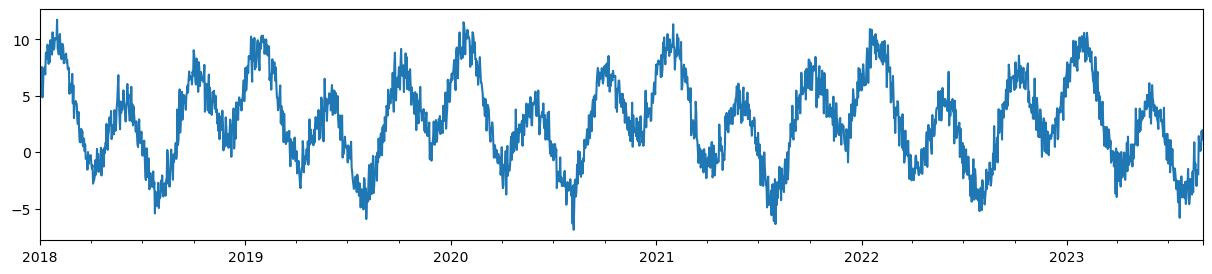

In [120]:
y.plot(figsize=(15, 3))

In [121]:
df = pd.DataFrame([X, y]).T

## This won't work at all

We'll use ordinary least squares linear regression throughout this notebook.

Let's see what happens if we try to use linear, monotonic time as the predictor variable.

In [179]:
from sklearn.linear_model import LinearRegression

model_0 = LinearRegression()
model_0.fit(df.loc[:'2021', ['X']], df.loc[:'2021', 'y'])

df['y_0'] = model_0.predict(df[['X']])

<AxesSubplot: title={'center': 'linear monotonic time'}>

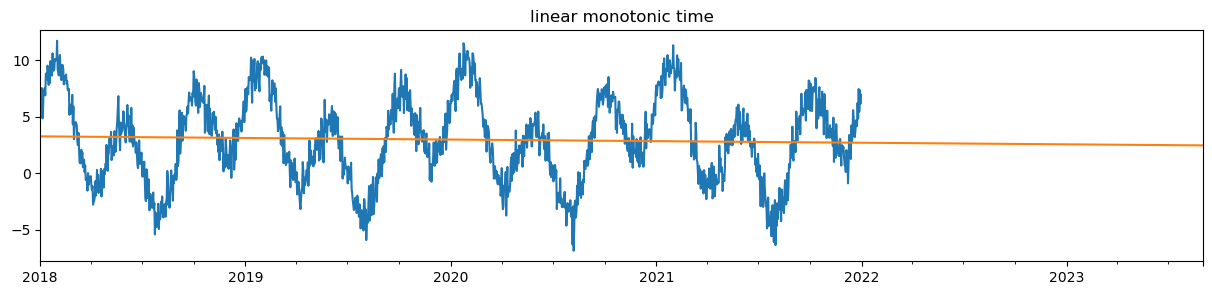

In [180]:
df.loc[:'2021', 'y'].plot(figsize=(15,3))
df['y_0'].plot(figsize=(15,3), title='linear monotonic time')

Not surprising: this feature contains no information. The best it can do is predict the mean of the signal.

Another naive approach would be to try to encode the month as an integer:

<AxesSubplot: title={'center': 'Integer month'}>

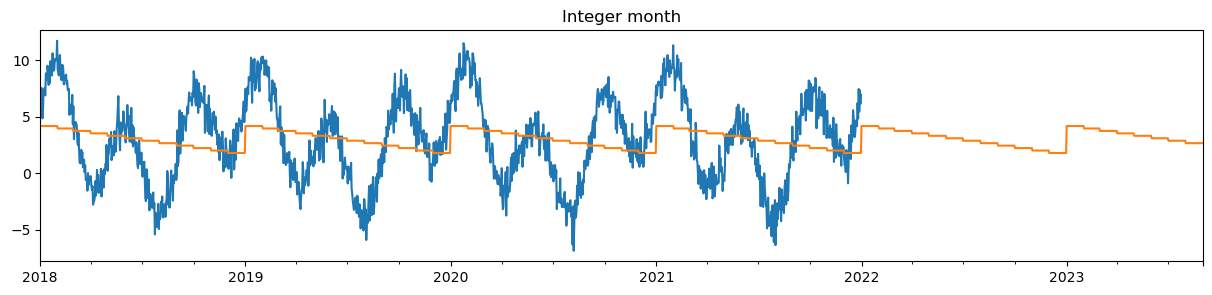

In [183]:
df['month'] = df.index.month

model_00 = LinearRegression()
model_00.fit(df.loc[:'2021', ['month']], df.loc[:'2021', 'y'])

df["y_00"] = model_00.predict(df.loc[:, ['month']])
df.loc[:'2021', 'y'].plot(figsize=(15,3))
df.loc[:, 'y_00'].plot(figsize=(15,3), title="Integer month")

This is an *ordinal* encoding. The model uses these integers as numbers with order and magnitude, not just as categorical labels. This is fine for some kinds of data, like linearly binned temperature data (say), because bin 3 is similar to bin 4, and bin 6 is twice bin 3, and so on. But it doesn't work for categories like rock type ('soft', 'hard', 'indie', 'glam', etc).

And at first glance you might think months or days of the week are ordinal, but there is this circular aspect where Monday and Sunday are as far apart as Monday and Tuesday.

In our case, the model is linear in 'month'. We are imposing the strong constraint that October is 2 &times; May, and January is as unlike December as you can be.

/home/matt/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


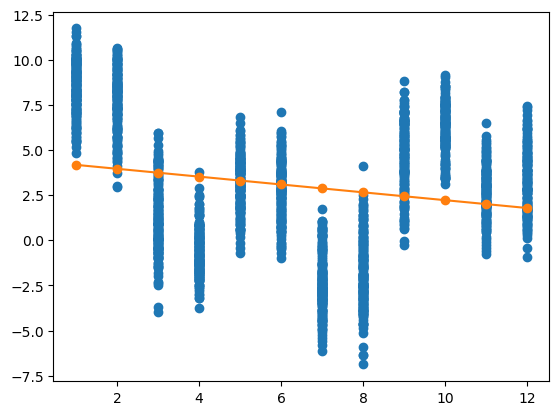

In [190]:
plt.scatter(df.index.month, df['y'])
x_ = (np.arange(12) + 1).reshape(-1, 1)
y_ = model_00.predict(x_)
plt.plot(x_, y_, 'o-', c='C1')

## Use one-hot encoding

We need to break this constraint.

A very common approach to encoding non-ordinal categorical variables is **one-hot encoding**. [Read the Wikipedia page about it.](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics)

In particular, we use 'dummy encoding', which is one-hot encoding but with one of the features dropped. The idea behind this is to avoid perfect multi-colinearity (perfectly correlated features), which can break the numerical tractability of least-squares. [Here's why.](https://en.wikipedia.org/wiki/Multicollinearity)

[Pandas](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) and [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) can each compute the dummy encoding.

In [135]:
X_1 = pd.DataFrame(
    data=pd.get_dummies(X.index.month, drop_first=True, prefix="month")
)
X_1.index = X.index
X_1.resample('M').max()

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2018-01-31,0,0,0,0,0,0,0,0,0,0,0
2018-02-28,1,0,0,0,0,0,0,0,0,0,0
2018-03-31,0,1,0,0,0,0,0,0,0,0,0
2018-04-30,0,0,1,0,0,0,0,0,0,0,0
2018-05-31,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,0,0,1,0,0,0,0,0,0,0,0
2023-05-31,0,0,0,1,0,0,0,0,0,0,0
2023-06-30,0,0,0,0,1,0,0,0,0,0,0
2023-07-31,0,0,0,0,0,1,0,0,0,0,0


<AxesSubplot: title={'center': 'One-hot'}>

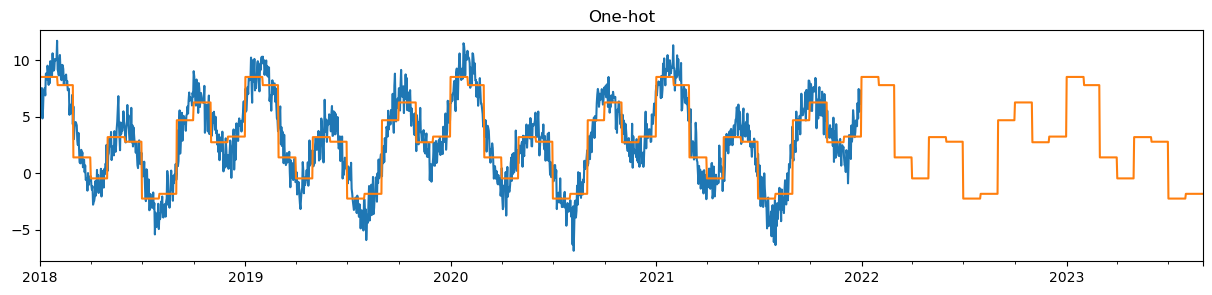

In [136]:
model_1 = LinearRegression()
model_1.fit(X_1.loc[:'2021'], df.loc[:'2021', 'y'])

df["y_1"] = model_1.predict(X_1)
df.loc[:'2021', 'y'].plot(figsize=(15,3))
df.loc[:, 'y_1'].plot(figsize=(15,3), title="One-hot")

## Sine/cosine transformers

A common approach with cyclical features is to transform them into coordinates around a circle using sin and cos functions.

In [137]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [141]:
df['day'] = df.index.day_of_year
df['month'] = df.index.month

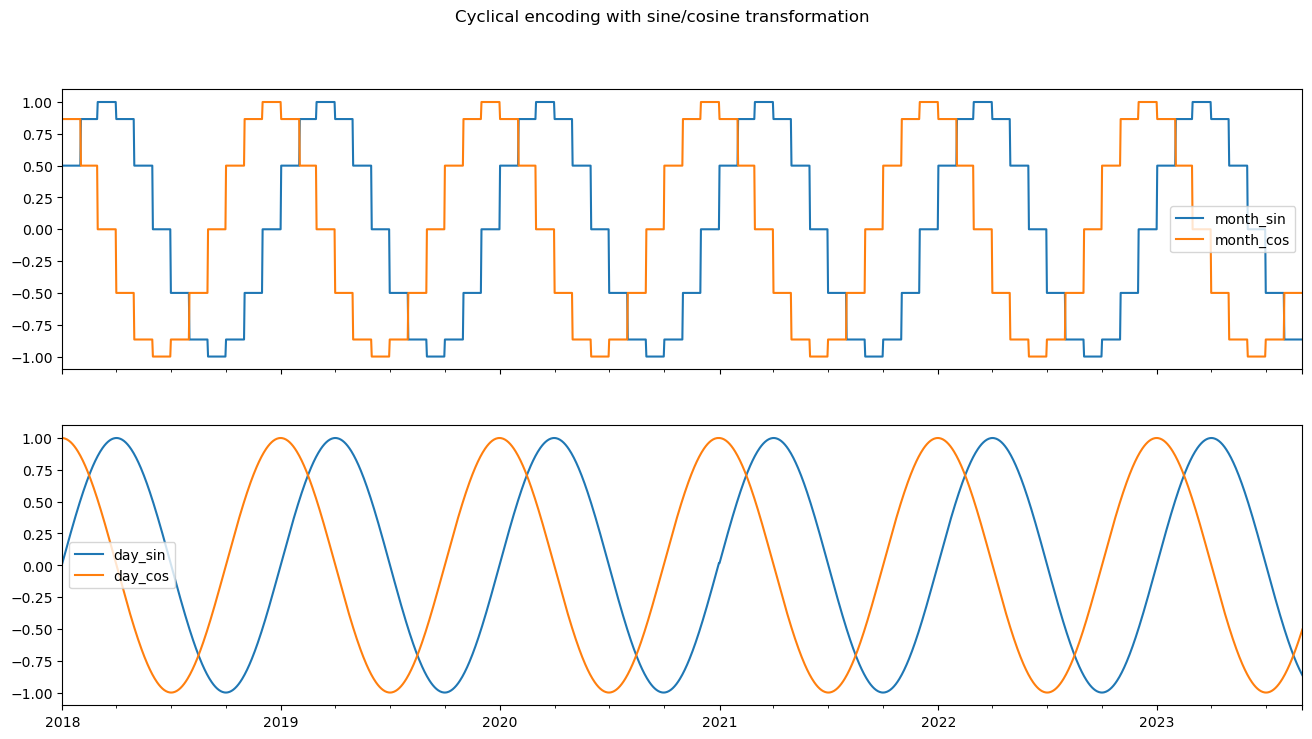

In [142]:
df["month_sin"] = sin_transformer(12).fit_transform(X_2)["month"]
df["month_cos"] = cos_transformer(12).fit_transform(X_2)["month"]

df["day_sin"] = sin_transformer(365).fit_transform(X_2)["day"]
df["day_cos"] = cos_transformer(365).fit_transform(X_2)["day"]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16,8))
df[["month_sin", "month_cos"]].plot(ax=ax[0])
df[["day_sin", "day_cos"]].plot(ax=ax[1])
plt.suptitle("Cyclical encoding with sine/cosine transformation");

In [167]:
X_2 = df.loc[:, ["day_sin", "day_cos", "month_sin", "month_cos"]]

<AxesSubplot: title={'center': 'Sinusoidal encoding'}>

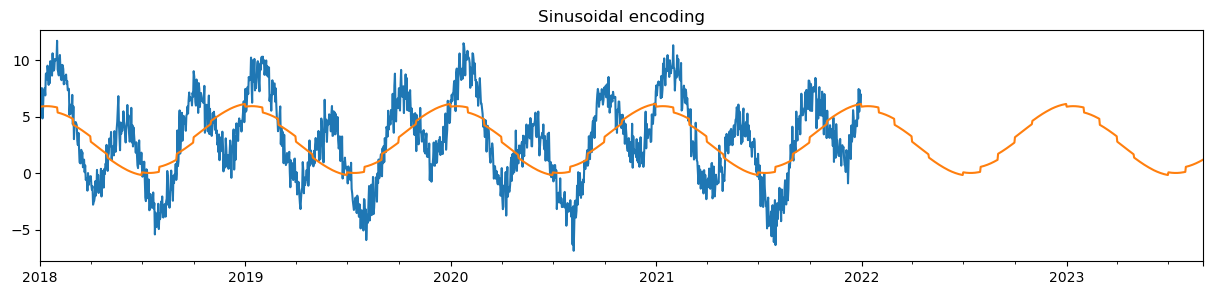

In [168]:
model_2 = LinearRegression()
model_2.fit(X_2.loc[:'2021'], df.loc[:'2021', 'y'])

df["y_2"] = model_2.predict(X_2)
df.loc[:'2021', 'y'].plot(figsize=(15,3))
df.loc[:, 'y_2'].plot(figsize=(15,3), title="Sinusoidal encoding")

It seemed intuitively sound, but in fact it does not even work as well as the one-hot encoding.

## Radial basis function

RBFs are everywhere these days, although they are a fairly new idea (boomed in the 1990's I think). 

We can make a function that describes the distance of a time point from periodic moments, eg the first of the month.

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

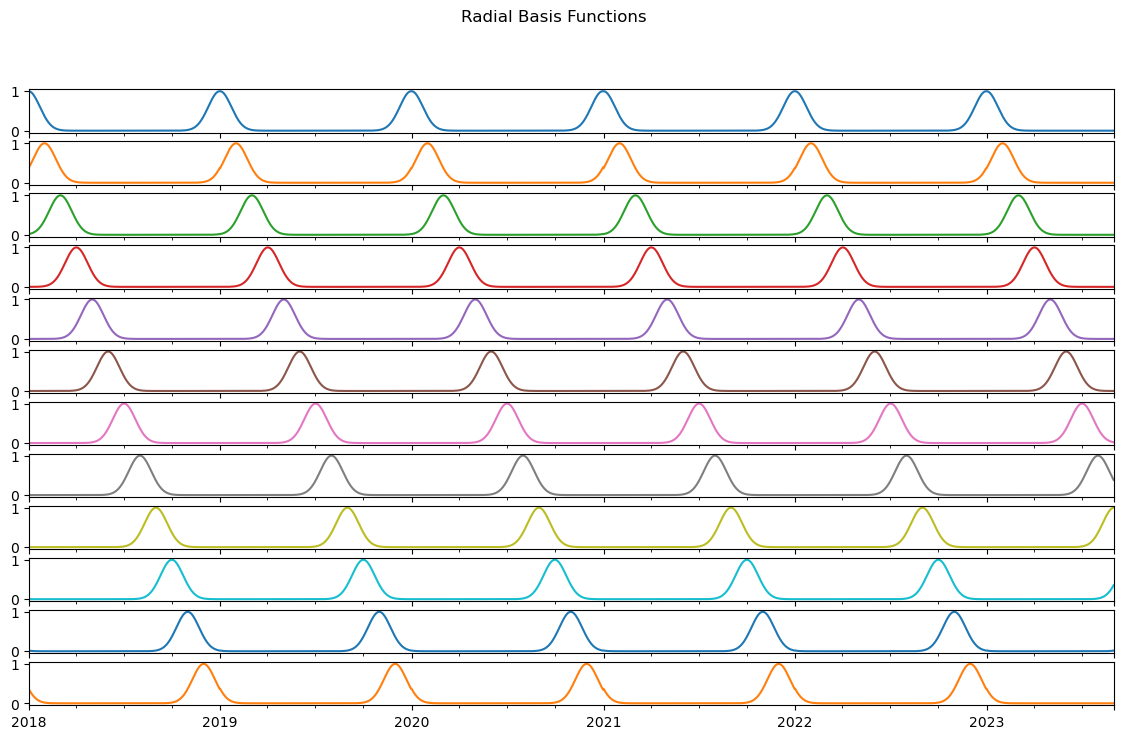

In [174]:
from sklego.preprocessing import RepeatingBasisFunction

rbf = RepeatingBasisFunction(n_periods=12,
                             column="day",
                             input_range=(1, 365),
                             remainder="drop"
                            )

rbf.fit(df)
X_3 = pd.DataFrame(index=X.index,
                   data=rbf.transform(df)
                  )

X_3.plot(subplots=True, figsize=(14, 8),
         sharex=True, title="Radial Basis Functions",
         legend=False
        )

These turn out to work really well.

<AxesSubplot: title={'center': 'RBFs'}>

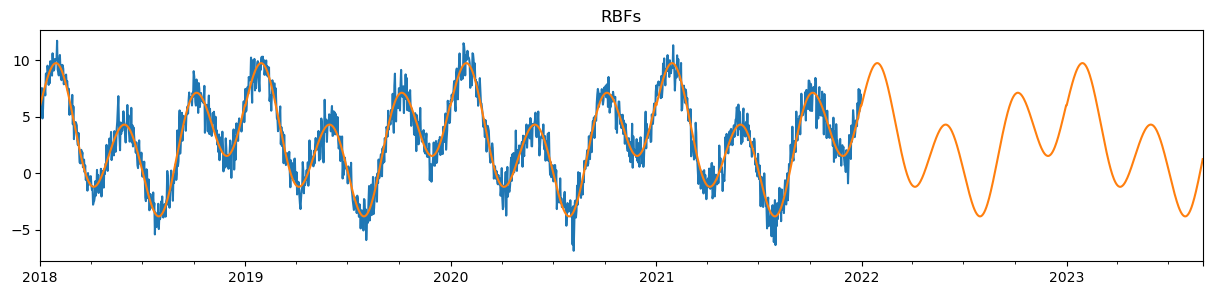

In [178]:
model_3 = LinearRegression()
model_3.fit(X_3.loc[:'2021'], df.loc[:'2021', 'y'])

df["y_1"] = model_3.predict(X_3)
df.loc[:'2021', 'y'].plot(figsize=(15,3))
df.loc[:, 'y_1'].plot(figsize=(15,3), title="RBFs")

Hm, seems like an interesting way to spectrally decompose signals...? 🤔